<a href="https://colab.research.google.com/github/iamchetry/DeepQNetworks/blob/main/RLAssignment2DoubleDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Utility Functions

In [ ]:
!sudo apt update
!sudo apt install xvfb
!pip install gym
!pip3 install box2d-py
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,622 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [52.7 kB]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,402 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security

In [ ]:
import os
from pyvirtualdisplay import Display
import gym
from gym import spaces
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40)
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import math
import glob
import io
import base64
from IPython.display import HTML
from IPython.display import clear_output
from IPython import display as ipythondisplay
import PIL

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as T

from collections import namedtuple
from tqdm import tqdm
import time 
from google.colab import widgets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.pos  = 0
    
    def push(self, state, action, reward, next_state, done):

        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)
        
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, batch_size):
        
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        samples = [self.buffer[idx] for idx in indices]
        
        batch = np.asarray(list(zip(*samples)))
        states = np.concatenate(batch[0])
        actions = batch[1]
        rewards = batch[2]
        next_states = np.concatenate(batch[3])
        dones = batch[4]
        
        return states, actions, rewards, next_states, dones, indices

    def __len__(self):
        return len(self.buffer)

In [ ]:
def get_target(dqn_model, target_model, next_state, reward, gamma, done):
  dqn_model.eval()
  target_model.eval()
  
  with torch.no_grad():
    next_actions = dqn_model(next_state)
    next_q_values = target_model(next_state)
    next_q_values = next_q_values.gather(1, next_actions.max(1)[1].unsqueeze(1)).squeeze(1)

  exp_q_value = reward+gamma*next_q_values*(1-done)
  return exp_q_value

In [ ]:
def loss_and_back(replay_buffer, batch_size, device, dqn_model, target_model, gamma, optimizer):
    state, action, reward, next_state, done, indices = replay_buffer.sample(batch_size) 

    state = torch.tensor(state.astype('float') ).float().to(device) 
    next_state = torch.tensor(next_state.astype('float') ).float().to(device)
    action = torch.tensor(action.astype('float') ).long().to(device)
    reward = torch.tensor(reward.astype('float') ).float().to(device)
    done = torch.tensor(done.astype('float') ).float().to(device)
    
    dqn_model.train()

    q_values = dqn_model(state) #feedforward

    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1) # Q values for actions sampled from the replay buffer

    expected_q_value = get_target(dqn_model, target_model, next_state, reward, gamma, done)

    loss = F.mse_loss(q_value,expected_q_value)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
def plot(frame_idx, episodes, rewards, epsilons):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. cumulative reward: %s' % (episodes, rewards[-1:]))
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.plot(range(episodes),rewards)
    plt.subplot(132)
    plt.title('Epsilon Decay')
    plt.xlabel("Frames")
    plt.ylabel("Epsilon")
    plt.plot(epsilons)
    plt.show()


In [ ]:
def plotGreedy(rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.title('reward: %s' % (rewards))
    plt.plot(rewards)
    plt.show()

In [ ]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions, device):
        super().__init__()
        
       #sequential model
        self.layers = nn.Sequential(
          nn.Linear(num_inputs,64), #INPUT LAYER
          nn.ReLU(),
          nn.Linear(64,128),  #HIDDEN LAYER 1
          nn.ReLU(),
          nn.Linear(128,256), #HIDDEN LAYER 2
          nn.ReLU(),
          nn.Linear(256,num_actions), #OUTPUT LAYER
        )
        

        self.num_actions = num_actions
        self.device=device
        
    def forward(self, x):
        op = self.layers(x)
        return op
    
    def act(self, state, epsilon, env):
        state = torch.tensor(state).float().unsqueeze(0).to(self.device)
        if random.random() > epsilon:
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0].item()
        else:
            action = np.random.choice(env.action_space.n)
        return action

In [ ]:
def update_target(dqn_model, target_model):
    target_model.load_state_dict(dqn_model.state_dict())

In [ ]:
def basis_transform(state):
    return np.asarray(state)

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
# ---- Source : https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
def evalTrainedModel(env_name, dqn_model):
  env = gym.make(env_name)
  env = wrap_env(env)

  frame = env.reset()
  rewards_list=[]

  for episode in range(1, 6):
    is_done = False
    counter = 0
    tot_reward = 0
    while not is_done:
      with torch.no_grad():
        inpt = torch.tensor(frame).float().unsqueeze(0).to(device)
        action = dqn_model(inpt).squeeze().argmax().item()
        frame, reward, is_done, _ = env.step(action)
        counter += 1
        tot_reward += reward

      if is_done:
        rewards_list.append(tot_reward)
        plotGreedy(rewards_list)
        frame = env.reset()

  env.close()
  show_video()

# Creating the Grid Environment

The below code defines a deterministic environment with a set of 4 actions:\
0 = Down\
1 = Up\
2 = Right\
3 = Left \
There are total 25 states: $S \in [0, 24]$, and the reward set $R \in \{-3,-1,0,5,10\}$. Our agent is an Alpha wolf trying to reach his Luna wolf in the goal state 24 with the reward of 10. The states s = 13, 16 are the intermediate states that contain a moonstone to be collected with a reward of r = 5. These states can only be entered once and this reward can only be collected once. There are also negative states, s = 4, 7, 10, 22 which are rogue territories and have a reward of -3. The agent receives a reward of -1 for all left and up actions i.e. the actions that take it away from goal. An episode starts from the initial state $s=0, s \in S$, and terminates either when the agent reaches the goal state $s=24, s \in S$, or a maximum iteration of 10. 

In [ ]:
class GridEnvironmentSt(gym.Env):
  metadata = { 'render.modes': []}

  def __init__(self, moonstone_states= [(3,1),(2,3)], rogue_states= [(2,0),(1,2),(4,2),(0,4)]):
    self.observation_space= spaces.Discrete(25)
    self.action_space= spaces.Discrete(4)
    self.max_timesteps=10
    self.moonstone_states= moonstone_states
    self.rogue_states= rogue_states
    
  def create_state(self,alpha_pos,luna_pos):
    state= np.zeros((5,5))
    state[tuple(luna_pos)] = 0.85

    for i in self.moonstone_states:
      state[i]= 0.7
    
    for i in self.rogue_states:
      state[i]= 0.5

    state[tuple(alpha_pos)] = 1.0

    return state

  def reset(self):
    self.timestep = 0
    self.luna_pos = [4,4]

    self.alpha_pos = [0,0]
    self.moonstone_states= [(3,1),(2,3)]

    self.state= self.create_state(self.alpha_pos,self.luna_pos)

    observation = self.alpha_pos

    return observation

  def step(self,action):

    if action == 0:
      self.alpha_pos[0] +=1
    if action == 1:
      self.alpha_pos[0] -=1
    if action == 2:
      self.alpha_pos[1] +=1
    if action == 3:
      self.alpha_pos[1] -=1

    self.alpha_pos= np.clip(self.alpha_pos,0,4)

    self.state= self.create_state(self.alpha_pos,self.luna_pos)

    observation= self.alpha_pos
    
    self.timestep +=1

    reward= 0
    if (self.alpha_pos == self.luna_pos).all():
      reward = 10

    for i in self.moonstone_states:
      if (i == self.alpha_pos).all():
        reward = 5
        self.moonstone_states.remove(i)
    
    for i in self.rogue_states:
      if (i ==  self.alpha_pos).all():
        reward = -3

    if action == 1 or action == 3:
      reward-=1

    done = True if (self.timestep >= self.max_timesteps) or (self.alpha_pos == self.luna_pos).all() else False
    info= {}

    return observation, reward, done, info

  def render(self):
        plt.imshow(self.state)

In [ ]:
def grid_world_special_case(dqn_model):
  env = GridEnvironmentSt()
  frame = env.reset()
  frame = basis_transform(frame)
  rewards_list=[]

  for frame_idx in range(1, 6):
    is_done = False
    counter = 0
    tot_reward = 0

    while not is_done:
      with torch.no_grad():
        inpt = torch.tensor(frame).float().unsqueeze(0).to(device)
        action = dqn_model(inpt).squeeze().argmax().item()
        frame, reward, is_done, info = env.step(action)
        frame = basis_transform(frame)
        counter += 1
        tot_reward += reward
        
        if is_done:
          rewards_list.append(tot_reward)
          plotGreedy(rewards_list)
          frame = env.reset()
          frame = basis_transform(frame)

In [ ]:
def grid_world_main():
  env = GridEnvironmentSt()
  observation = env.reset()
  env.render()

  epsilon_start = 1.0
  epsilon_final = 0.01
  epsilon_decay = 1000

  epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

  lr = 0.001
  inp = 2
  dqn_model = DQN(inp, env.action_space.n, device).to(device)
  target_model  = DQN(inp, env.action_space.n, device).to(device)

  optimizer = optim.SGD(dqn_model.parameters(), lr=lr, momentum = 0.9)

  replay_buffer = ReplayBuffer(5000)
  update_target(dqn_model, target_model)

  num_frames = 10000
  num_episodes=0
  batch_size = 8
  gamma = 0.9

  losses = []
  all_rewards = []
  epsilons = []
  episode_reward = 0

  state = env.reset()
  state = basis_transform(state)
  count=0
  timesteps=[]

  for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    epsilons.append(epsilon)

    action = dqn_model.act(state, epsilon, env)

    next_state, reward, done, info = env.step(action)
    next_state = basis_transform(next_state)

    replay_buffer.push(state, action, reward, next_state, done)
    state = next_state
    episode_reward += reward
    count+=1
      
    if done:
      num_episodes+=1
      state = env.reset()
      state = basis_transform(state)
      all_rewards.append(episode_reward)
      episode_reward = 0
      timesteps.append(count)
      count=0

      if num_episodes % 20 == 0:
        plot(frame_idx, num_episodes, all_rewards, epsilons)
        print("Average Timesteps per episode for ",num_episodes, " episodes are : ", np.mean(timesteps))
        
    if len(replay_buffer) > batch_size:
      loss = loss_and_back(replay_buffer, batch_size, device, dqn_model, target_model, gamma, optimizer)
      losses.append(loss.item())
        
    if frame_idx % 50 == 0:
      update_target(dqn_model, target_model)

    if frame_idx == num_frames:
      plot(frame_idx, num_episodes, all_rewards, epsilons)
      print("Average Timesteps per episode for ",num_episodes, " episodes are : ", np.mean(timesteps))

  return dqn_model

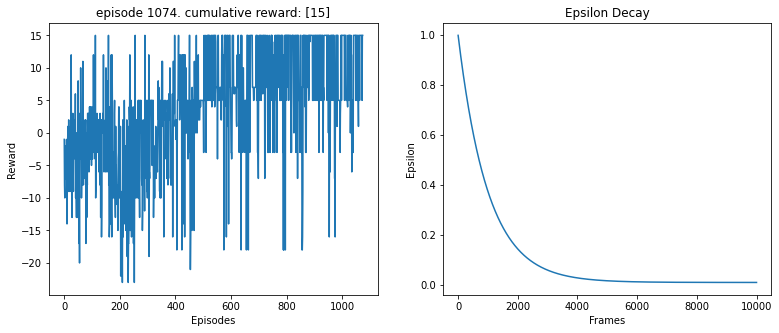

Average Timesteps per episode for  1074  episodes are :  9.309124767225326


In [ ]:
# dqn_model = grid_world_main()

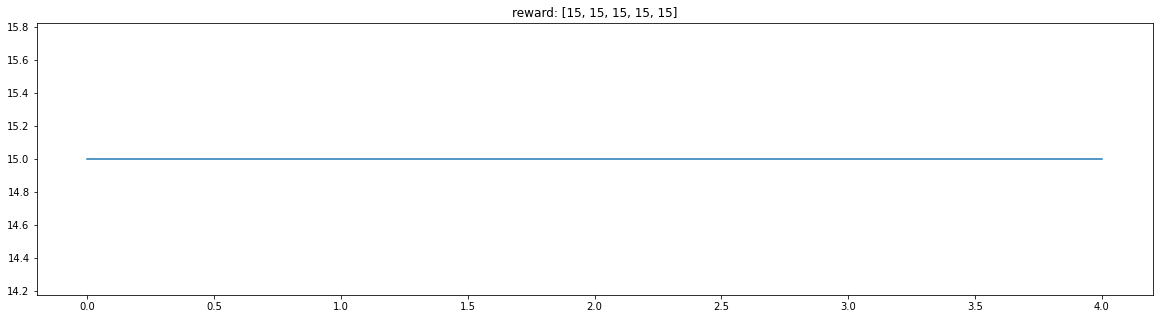

In [ ]:
# grid_world_special_case(dqn_model)

# OpenAI Gym CartPole environment

In [ ]:
def cart_pole_main():
  env = gym.make('CartPole-v1')
  env = wrap_env(env)

  frame = env.reset()

  is_done = False
  while not is_done:
    frame, reward, is_done, _ = env.step(env.action_space.sample())

  env.close()
  show_video()

  epsilon_start = 1.0
  epsilon_final = 0.01
  epsilon_decay = 15000

  epsilon_by_frame_CP = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

  learningrate = 0.0002

  dqn_model = DQN(env.observation_space.shape[0], env.action_space.n, device).to(device)
  target_model  = DQN(env.observation_space.shape[0], env.action_space.n, device).to(device)


  optimizer = optim.Adam(dqn_model.parameters(), lr=learningrate)

  replay_buffer = ReplayBuffer(100000)

  update_target(dqn_model, target_model)

  num_frames = 300000
  num_episodes = 0
  batch_size = 128
  gamma = 0.9

  losses = []
  all_rewards = []
  episode_reward = 0
  epsilons=[]

  state = env.reset()

  count=0
  timesteps=[]

  for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame_CP(frame_idx)
    epsilons.append(epsilon)

    action = dqn_model.act(state,epsilon,env)

    next_state, reward, done, info = env.step(action)
    next_state = basis_transform(next_state)

    replay_buffer.push(state, action, reward, next_state, done)
    state = next_state
    episode_reward += reward
    count+=1
      
    if done:
      num_episodes+=1
      state = env.reset()
      state = basis_transform(state)
      all_rewards.append(episode_reward)
      episode_reward = 0
      timesteps.append(count)
      count=0

      if num_episodes % 50 == 0:
        plot(frame_idx, num_episodes, all_rewards, epsilons)
        print("Average Timesteps per episode for ",num_episodes, " episodes are : ", np.mean(timesteps))
        
    if len(replay_buffer) > batch_size:
      loss = loss_and_back(replay_buffer, batch_size, device, dqn_model, target_model, gamma, optimizer)
      losses.append(loss.item())
        
    if frame_idx % 10 == 0:
      update_target(dqn_model, target_model)

    if frame_idx == num_frames:
      plot(frame_idx, num_episodes, all_rewards, epsilons)
      print("Average Timesteps per episode for ",num_episodes, " episodes are : ", np.mean(timesteps))

  return dqn_model

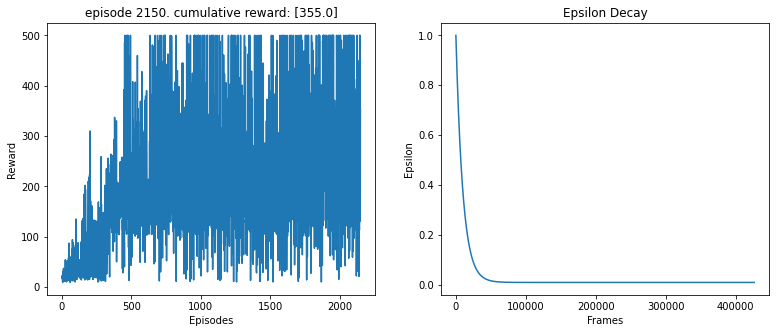

Average Timesteps per episode for  2150  episodes are :  198.50418604651162


In [ ]:
# dqn_model = cart_pole_main()

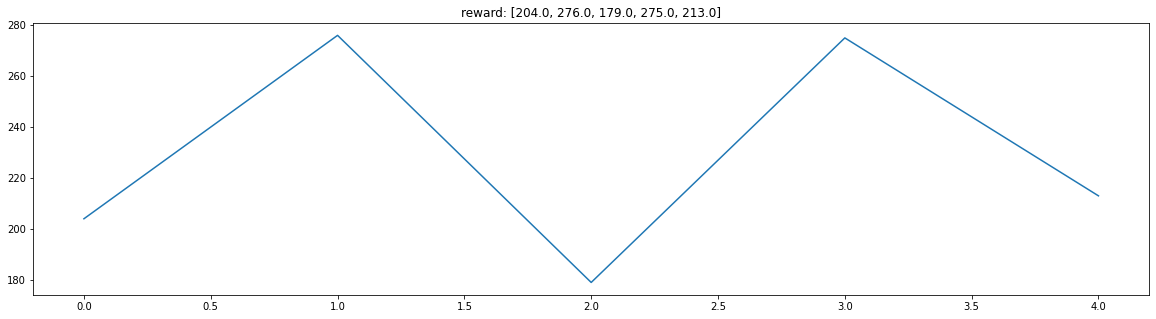

In [ ]:
# evalTrainedModel('CartPole-v1', dqn_model)

# OpenAI Gym LunarLander Environment

In [ ]:
def lunar_lander_main():
  env = gym.make('LunarLander-v2')
  env = wrap_env(env)

  frame = env.reset()

  is_done = False
  while not is_done:
    frame, reward, is_done, _ = env.step(env.action_space.sample())

  env.close()
  show_video()

  epsilon_start = 0.9
  epsilon_final = 0.05
  epsilon_decay = 10000

  epsilon_by_frame_LL = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

  learningrate = 0.0002

  dqn_model = DQN(env.observation_space.shape[0], env.action_space.n, device).to(device)
  target_model  = DQN(env.observation_space.shape[0], env.action_space.n, device).to(device)

  optimizer = optim.Adam(dqn_model.parameters(), lr=learningrate)

  replay_buffer = ReplayBuffer(100000)
  print(len(replay_buffer))

  update_target(dqn_model, target_model)

  num_frames = 200000
  num_episodes = 0
  batch_size = 512
  gamma = 0.99

  losses = []
  all_rewards = []
  episode_reward = 0
  epsilons=[]

  count=0
  timesteps=[]

  state = env.reset()

  for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame_LL(frame_idx)
    epsilons.append(epsilon)

    action = dqn_model.act(state,epsilon, env)

    next_state, reward, done, info = env.step(action)
    next_state = basis_transform(next_state)

    replay_buffer.push(state, action, reward, next_state, done)
    state = next_state
    episode_reward += reward
    count+=1
    
    if done or count>=500:
      num_episodes+=1
      state = env.reset()
      state = basis_transform(state)
      all_rewards.append(episode_reward)
      episode_reward = 0
      timesteps.append(count)
      count=0

      if num_episodes % 10 == 0:
        plot(frame_idx, num_episodes, all_rewards, epsilons)
        print("Average Timesteps per episode for ",num_episodes, " episodes are : ", np.mean(timesteps))
        
    if len(replay_buffer) > batch_size:
      loss = loss_and_back(replay_buffer, batch_size, device, dqn_model, target_model, gamma, optimizer)
      losses.append(loss.item())
        
    if frame_idx % 10 == 0:
      update_target(dqn_model, target_model)

    if frame_idx == num_frames:
      plot(frame_idx, num_episodes, all_rewards, epsilons)
      print("Average Timesteps per episode for ",num_episodes, " episodes are : ", np.mean(timesteps))

  return dqn_model

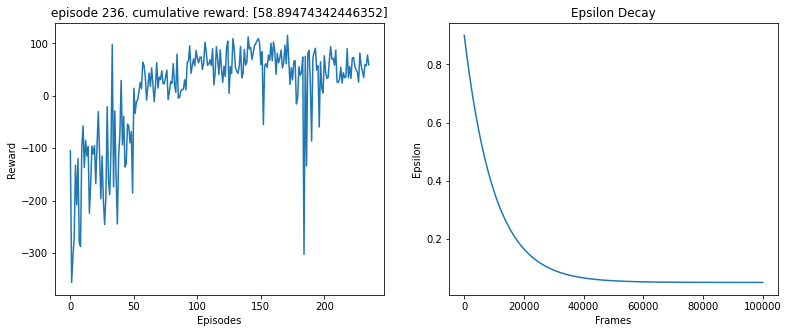

Average Timesteps per episode for  236  episodes are :  422.77966101694915


In [ ]:
# dqn_model = lunar_lander_main()

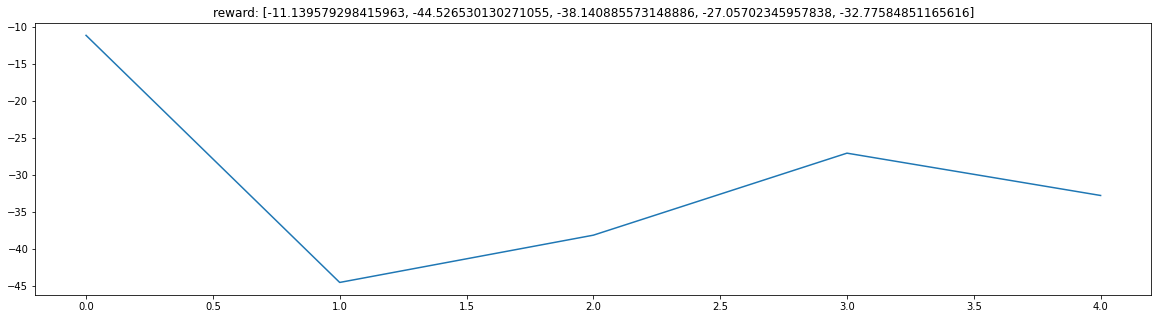

In [ ]:
# evalTrainedModel('LunarLander-v2', dqn_model)